In [2]:
import pandas as pd

df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)


In [3]:
df.shape
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

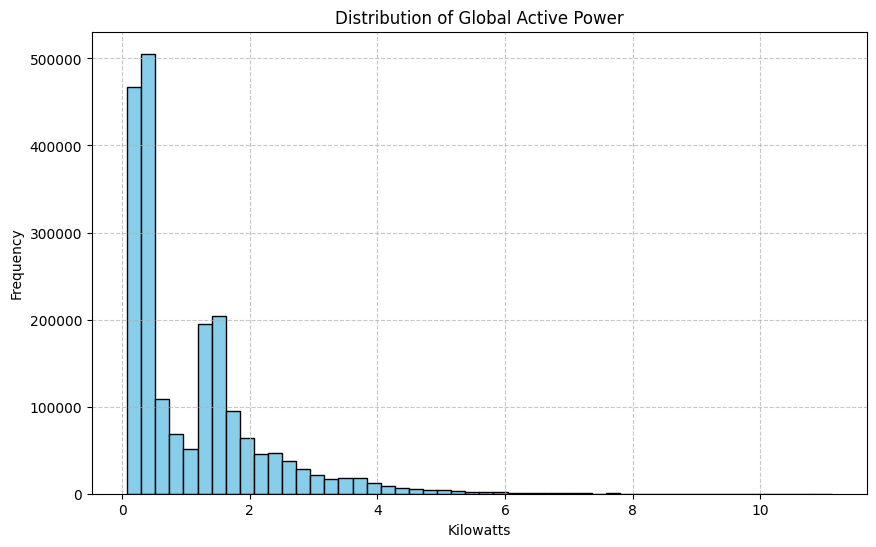

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['Global_active_power'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Global Active Power')
plt.xlabel('Kilowatts')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


C:\Users\bhuva\AppData\Local\Temp\ipykernel_15572\2426562525.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


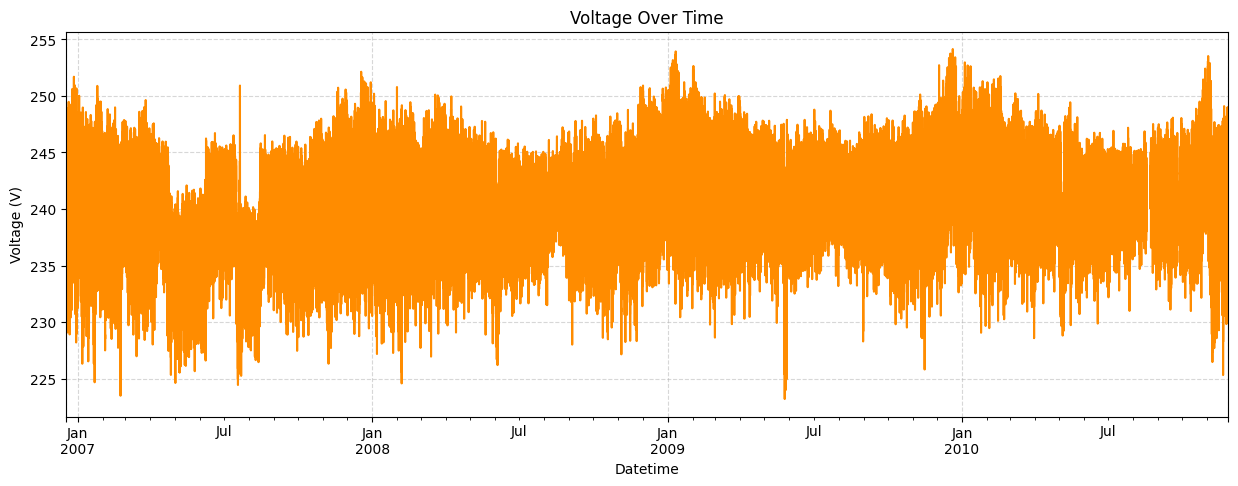

In [5]:
plt.figure(figsize=(15, 5))
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)
df['Voltage'].plot(color='darkorange')
plt.title('Voltage Over Time')
plt.ylabel('Voltage (V)')
plt.xlabel('Datetime')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


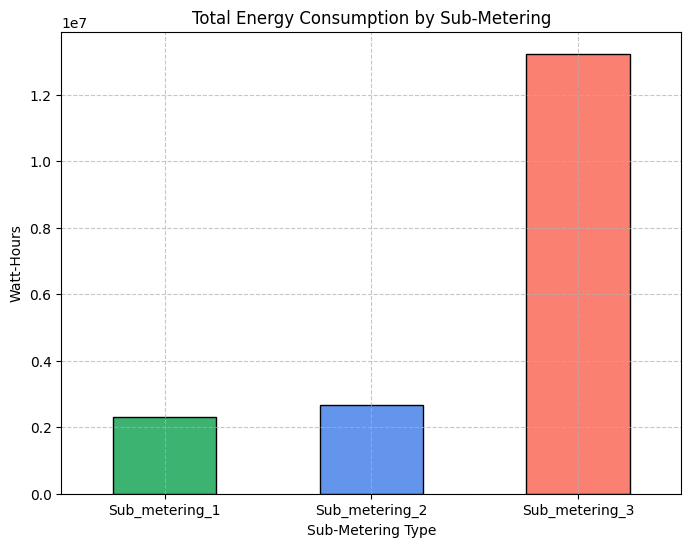

In [6]:
plt.figure(figsize=(8, 6))
sub_meter_totals = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].sum()
sub_meter_totals.plot(kind='bar', color=['mediumseagreen', 'cornflowerblue', 'salmon'], edgecolor='black')
plt.title('Total Energy Consumption by Sub-Metering')
plt.ylabel('Watt-Hours')
plt.xlabel('Sub-Metering Type')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


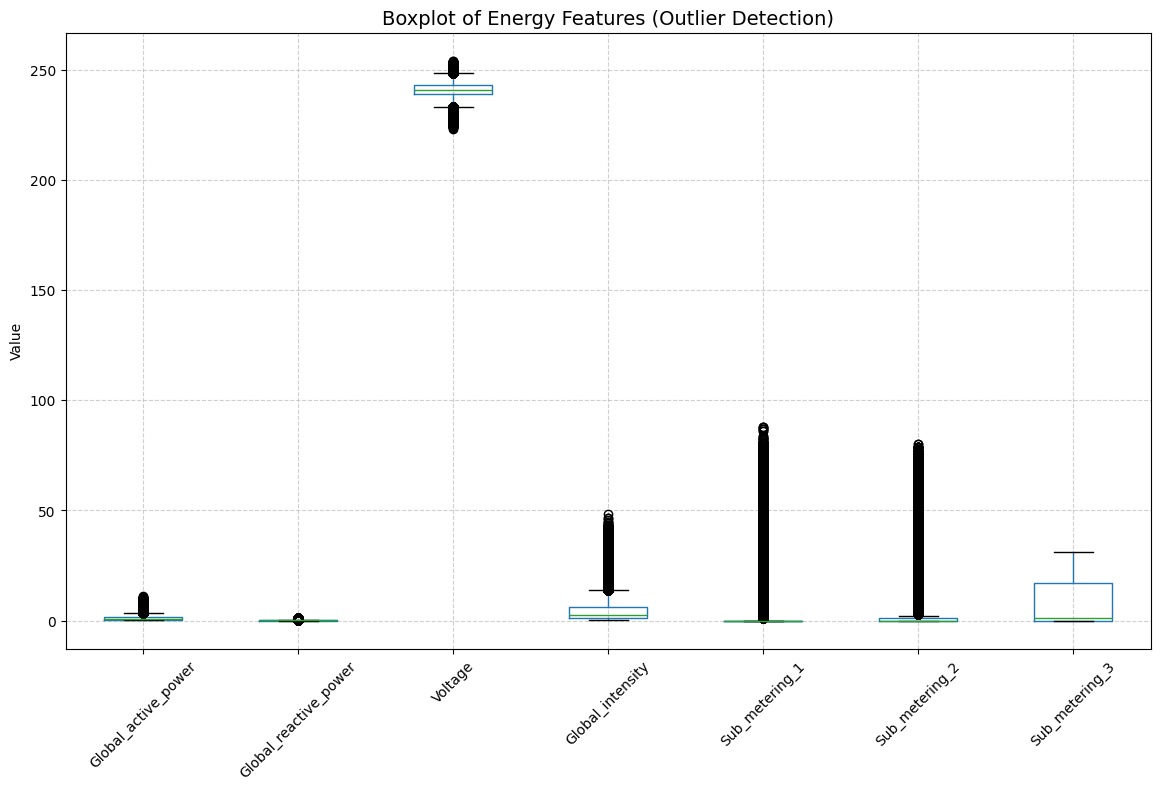

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

plt.figure(figsize=(14, 8))
df[numeric_cols].boxplot()
plt.title('Boxplot of Energy Features (Outlier Detection)', fontsize=14)
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


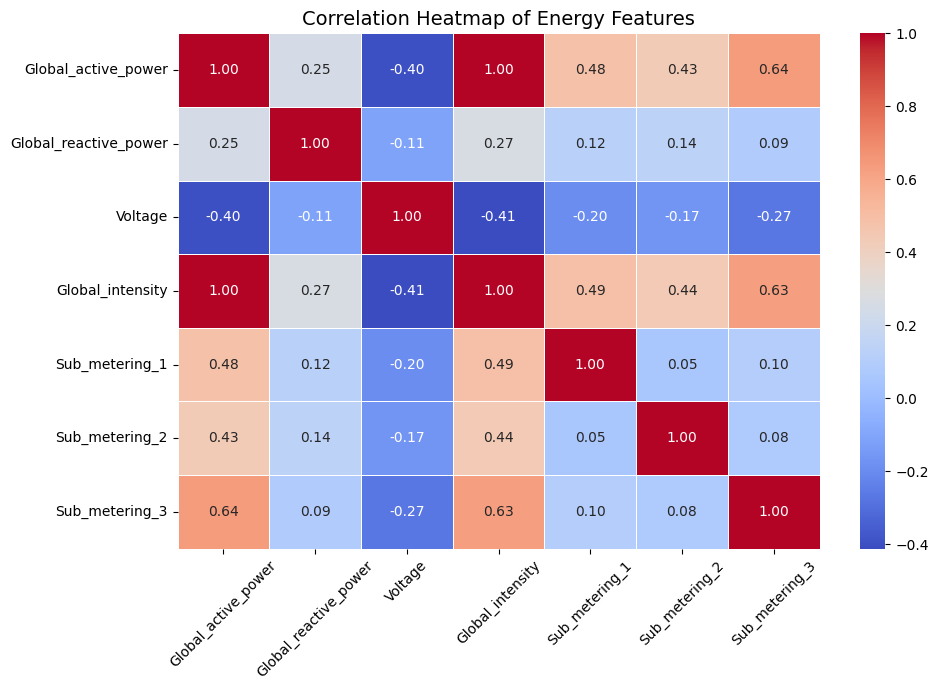

In [8]:
plt.figure(figsize=(10, 7))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Energy Features', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Convert 'Date' and 'Time' to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)

# Drop rows with missing values (25,979 rows ~1.25%)
df.dropna(inplace=True)

# Convert all remaining columns to float (already handled by na_values + dropna)
df = df.astype('float32')

# Create time-based features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month

# Add rolling average (3-hour window = 180 minutes for 1-min frequency)
df['rolling_mean_3h'] = df['Global_active_power'].rolling(window=180, min_periods=1).mean()

# Optional: View processed data
print(df.head())


                     Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:24:00                4.216                  0.418  234.839996   
2006-12-16 17:25:00                5.360                  0.436  233.630005   
2006-12-16 17:26:00                5.374                  0.498  233.289993   
2006-12-16 17:27:00                5.388                  0.502  233.740005   
2006-12-16 17:28:00                3.666                  0.528  235.679993   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-

In [6]:
# Step 1: Daily Aggregations
daily_df = df.resample('D').agg({
    'Global_active_power': ['mean', 'max', 'min'],
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

# Flatten multi-level column names
daily_df.columns = ['_'.join(col).strip() for col in daily_df.columns.values]

# Step 2: Lag Features (for modeling)
df['lag_1'] = df['Global_active_power'].shift(1)
df['lag_24h'] = df['Global_active_power'].shift(1440)  # 1-day lag assuming 1-min frequency

# Step 3: Derived Feature - Other Consumption (in watt-hours)
df['other_consumption'] = (df['Global_active_power'] * 1000 / 60) - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
)

# Step 4: Display outputs
print("🔹 Sample of Daily Aggregated Data:")
print(daily_df.head())

print("\n🔹 Sample of Lag + Other Consumption Features:")
print(df[['Global_active_power', 'lag_1', 'lag_24h', 'other_consumption']].dropna().head())


🔹 Sample of Daily Aggregated Data:
            Global_active_power_mean  Global_active_power_max  \
Datetime                                                        
2006-12-16                  3.053475                    7.706   
2006-12-17                  2.354486                    7.064   
2006-12-18                  1.530435                    6.158   
2006-12-19                  1.157079                    7.840   
2006-12-20                  1.545658                    5.988   

            Global_active_power_min  Global_reactive_power_mean  Voltage_mean  \
Datetime                                                                        
2006-12-16                    0.284                    0.088187    236.243759   
2006-12-17                    0.206                    0.156949    240.087021   
2006-12-18                    0.202                    0.112356    241.231689   
2006-12-19                    0.194                    0.104821    241.999298   
2006-12-20             

In [7]:
# 💡 Step 4: Minute-Level Model Training and Evaluation (Random Forest)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Drop rows with NaNs from lag/engineered features
model_df = df.dropna(subset=['lag_1', 'lag_24h', 'rolling_mean_3h', 'other_consumption'])

# Feature and target setup
features = [
    'lag_1', 'lag_24h', 'rolling_mean_3h',
    'hour', 'day', 'weekday', 'month',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'other_consumption'
]
target = 'Global_active_power'

X = model_df[features]
y = model_df[target]

# Train-test split (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Model training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print("📊 Random Forest Model Performance:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"R²   : {r2:.3f}")


📊 Random Forest Model Performance:
RMSE: 0.042
MAE : 0.006
R²   : 0.998


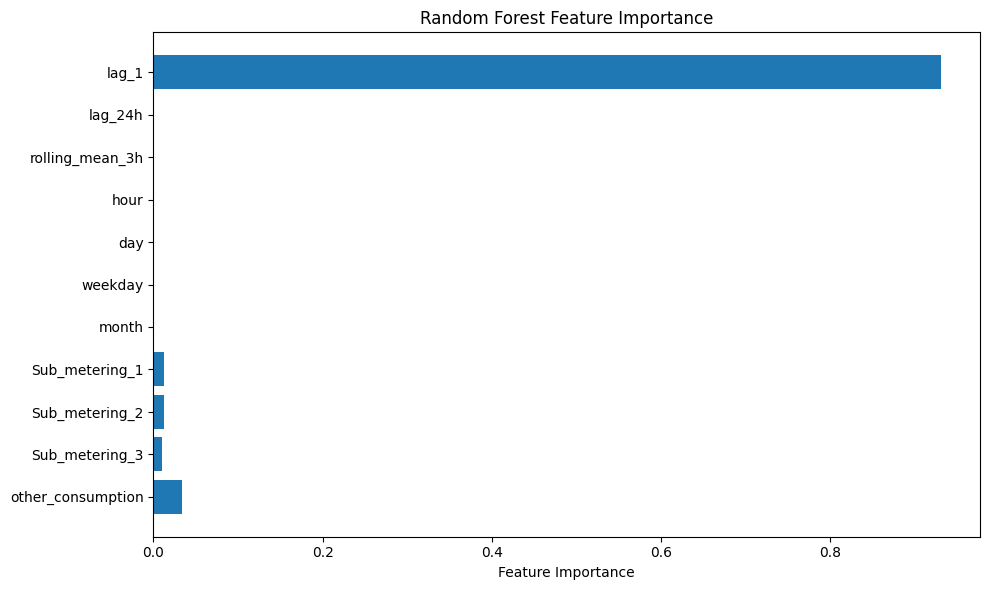

In [ ]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


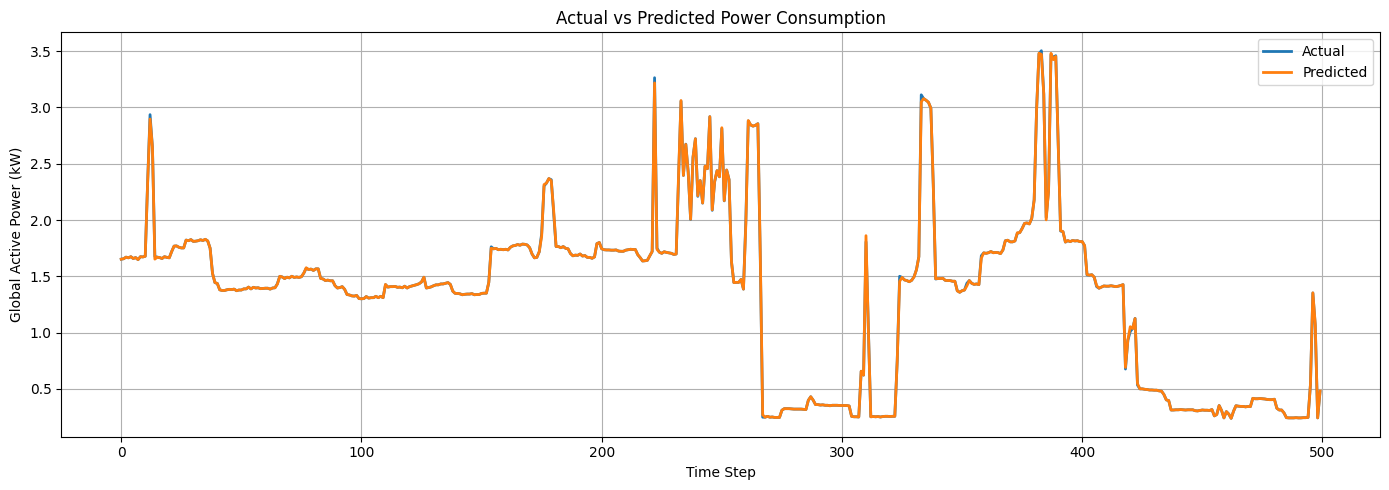

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test.values[:500], label='Actual', linewidth=2)
plt.plot(y_pred[:500], label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Power Consumption")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import joblib
joblib.dump(rf_model, 'power_consumption_rf_model.pkl')


['power_consumption_rf_model.pkl']

In [ ]:
results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred}, index=y_test.index)
results.to_csv('predicted_power_consumption.csv')
